In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit
import jax.random as random
rng = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
cm = sns.color_palette("mako_r", as_cmap=True)
from scipy.stats import gaussian_kde
from scipy.stats import gamma, lognorm
import pandas as pd

from mat_models import MR, mn_sigma_vmap as mn_sigma
from utils_node import init_params, NODE_model
from utils import train_jp, eval_Cauchy
from utils_diffusion import *

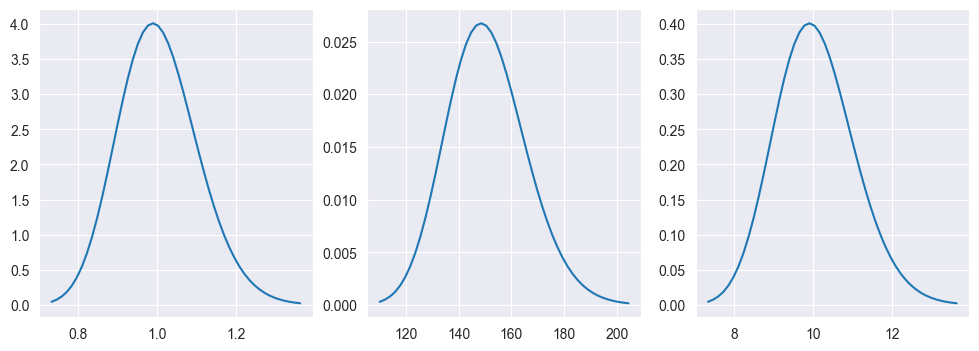

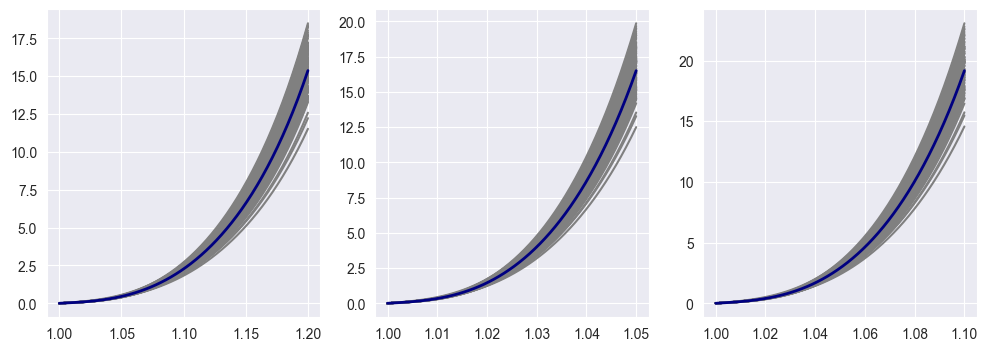

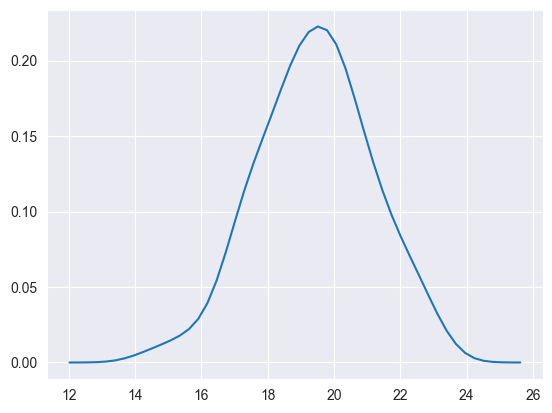

In [4]:
# Generate training data from May-Newmann model
MN_params  = [1.0,         150,         10] # baseline params
J = 100 # 10 different samples 
fig, ax = plt.subplots(1,3,figsize=(12,4))
MN_params_s = np.zeros((J,len(MN_params)))
theta = 1.0
tikzdata = []
for j in range(len(MN_params)):
    p = MN_params[j]
    s = 0.1
    scale = p
    x = np.linspace(lognorm.ppf(0.001, s, scale=scale), 
                    lognorm.ppf(0.999, s, scale=scale))
    y = lognorm.pdf(x, s, scale=scale)
    ax[j].plot(x,y)
    tikzdata.append([x,y])
    for i in range(J):
        MN_params_s[i,j] = lognorm.rvs(s, scale=p)

tikzdata = np.array(tikzdata).reshape(6,-1)
np.savetxt('tikz/fig_analytical_data/param_dist.csv', tikzdata.T, header='x1 y1 x2 y2 x3 y3', comments='')

# Given thse parameters, generate bunch of curves for different tests
# and plot to see: 3 different biaxial deformations going from strip biax, to off, to equi-biaxial 
lam_ls = np.linspace(1,1.2,50)
lam_vec = np.zeros((3*50,2))
for i in range(3):
    alpha = i/4
    lam_vec[i*50:(i+1)*50,0] = 1+alpha*(lam_ls-1)
    lam_vec[i*50:(i+1)*50,1] = 1+(1-alpha)*(lam_ls-1)

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
# all 10 samples
sigma_gt_s = []
header = 'x'
for j in range(J):
    sigma_gt_si = mn_sigma(lam_vec, MN_params_s[j])
    sigma_gt_s.append(sigma_gt_si)

    axs[0].plot(lam_vec[:50,1],         sigma_gt_si[0][:50]       ,color='grey')
    axs[1].plot(lam_vec[50:2*50,0],     sigma_gt_si[0][50:2*50]   ,color='grey')
    axs[2].plot(lam_vec[2*50:3*50,0],   sigma_gt_si[0][2*50:3*50] ,color='grey')
    header = header + ' y' + str(j)
tikzdata = np.vstack([lam_vec[2*50:3*50,0],np.array(sigma_gt_s)[:,0,2*50:3*50]]).T
np.savetxt('tikz/fig_analytical_data/data_sgmx_equi.csv', tikzdata, header = header, comments = '')
stat = tikzdata[-1,1:]
kernel = gaussian_kde(stat)
xmin = np.min(stat)
xmax = np.max(stat)
r = xmax-xmin
x = np.linspace(xmin - 0.3*r, xmax + 0.3*r)
y = kernel(x)
np.savetxt('tikz/fig_analytical_data/data_sgmx_at_1.1_equi.csv', np.stack([x,y]).T, header='x y', comments='')
fig, ax = plt.subplots()
ax.plot(x,y)

# mean response
sigma_gt_m = mn_sigma(lam_vec, MN_params)
axs[0].plot(lam_vec[:50,1],         sigma_gt_m[0][:50]      ,color='navy',linewidth=2)
axs[1].plot(lam_vec[50:2*50,0],     sigma_gt_m[0][50:2*50]  ,color='navy',linewidth=2)
axs[2].plot(lam_vec[2*50:3*50,0],   sigma_gt_m[0][2*50:3*50],color='navy',linewidth=2)


In [5]:
# Restructure the stress-stretch data a bit
lamx_all,   lamy_all    = np.array([lam_vec]*J).reshape([-1,2]).T     # Repeat the same lmx & lmy values J times
sigmax_all, sigmay_all  = np.array(sigma_gt_s).transpose([1,0,2]).reshape([2,-1])
lamb_sigma = np.vstack([lamx_all,lamy_all,sigmax_all,sigmay_all]).transpose()

## just the mean response
sigmax_r = lamb_sigma[:,2].reshape((J,150))
sigma_x_m = np.mean(sigmax_r,axis=0)
sigmay_r = lamb_sigma[:,3].reshape((J,150))
sigma_y_m = np.mean(sigmay_r,axis=0)
lamb_sigma_m = np.vstack([lam_vec[:,0],lam_vec[:,1],sigma_x_m,sigma_y_m]).transpose()

In [6]:
# Normalization factors
I1_factor = 3
I2_factor = 3
Psi1_factor = 1.0
Psi2_factor = 1.0
Psi_1_2_factor = 1.0
normalization = [I1_factor, I2_factor, Psi1_factor, Psi2_factor, Psi_1_2_factor]

# Define the loss function for when training all params
@jit
def loss_sig_all(params, lamb_sigma, normalization):
    # params come with all the common parameters first
    params_I1, params_I2, params_I1I2 = params

    model   = NODE_model(params_I1, params_I2, params_I1I2)
    lambx   = lamb_sigma[:,0]
    lamby   = lamb_sigma[:,1]
    sigmax  = lamb_sigma[:,2]
    sigmay  = lamb_sigma[:,3]
    sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

# Initialize NODEs and the optimizer
key = random.PRNGKey(0)
common_layers = [1, 5, 5]
sample_layers = [5,1]
params_all = init_params(common_layers, sample_layers, key)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(params_all)

# Train
params_all, train_loss, val_loss = train_jp(loss_sig_all, lamb_sigma_m, normalization, get_params, opt_update, opt_state, key, nIter = 100000, print_freq=10000)
with open('params/MN_node_params_all.npy', 'wb') as f:
    pickle.dump(params_all, f)

it 10000, train loss = 1.264994e+00
it 20000, train loss = 5.351806e-01
it 30000, train loss = 4.077770e-01
it 40000, train loss = 3.503038e-01
it 50000, train loss = 3.165032e-01
it 60000, train loss = 2.939159e-01
it 70000, train loss = 2.778976e-01
it 80000, train loss = 2.664299e-01
it 90000, train loss = 2.568403e-01
it 100000, train loss = 2.494186e-01


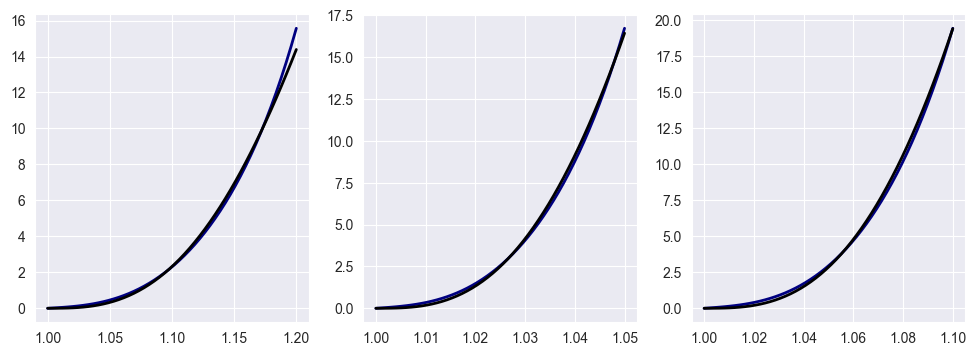

In [7]:
mymodel = NODE_model(*params_all)
# plot
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

axs[0].plot(lam_vec[:50,1],         lamb_sigma_m[:50,2],        color='navy',linewidth=2)
axs[1].plot(lam_vec[50:2*50,0],     lamb_sigma_m[50:2*50,2],    color='navy',linewidth=2)
axs[2].plot(lam_vec[2*50:3*50,0],   lamb_sigma_m[2*50:3*50,2],  color='navy',linewidth=2)

sigx,sigy = eval_Cauchy(lamb_sigma_m[:,0],lamb_sigma_m[:,1], mymodel, normalization)
axs[0].plot(lam_vec[:50,1],         sigx[:50],      color='k',linewidth=2)
axs[1].plot(lam_vec[50:2*50,0],     sigx[50:2*50],  color='k',linewidth=2)
axs[2].plot(lam_vec[2*50:3*50,0],   sigx[2*50:3*50],color='k',linewidth=2)

In [8]:
# fit individually 
params_I1, params_I2, params_I1I2 = params_all
params_I1c,params_I1s_m = params_I1
params_I2c,params_I2s_m = params_I2
params_I1I2c,params_I1I2s_m,params_I1I2_a = params_I1I2

# loss_sample = lambda mean_sample_params, X, normalization: loss_sig_all( ((params_I1c,mean_sample_params[0]),(params_I2c,mean_sample_params[1]),(params_I1I2c,mean_sample_params[2],params_I1I2_a)), X, normalization)
def loss_sample(sample_params, X, normalization): #This keeps the common params constant and varies sample_params
    params_I1 = (params_I1c, sample_params[0])
    params_I2 = (params_I2c, sample_params[1])
    params_I1I2 = (params_I1I2c, sample_params[2], params_I1I2_a)
    params = (params_I1, params_I2, params_I1I2)
    return loss_sig_all(params, X, normalization)

mean_sample_params = (params_I1s_m,params_I2s_m,params_I1I2s_m)

Sample_params = []

for j in range(J):
    sigx = sigma_gt_s[j][0]
    sigy = sigma_gt_s[j][1]
    lamb_sigma_j = np.vstack([lam_vec[:,0],lam_vec[:,1],sigx,sigy]).transpose()
    opt_init, opt_update, get_params = optimizers.adam(1e-3)
    opt_state = opt_init(mean_sample_params)

    print(j)
    sample_params, train_loss, val_loss = train_jp(loss_sample, lamb_sigma_j, normalization, get_params, opt_update, opt_state, key, nIter = 10000, print_freq=10000)
    Sample_params.append(sample_params)

with open('params/MN_node_sample_params.npy', 'wb') as f:
    pickle.dump(Sample_params, f)

it 10000, train loss = 4.280663e-01
it 10000, train loss = 1.079971e-01
it 10000, train loss = 2.445911e-01
it 10000, train loss = 3.151775e-01
it 10000, train loss = 1.374305e-01
it 10000, train loss = 2.140732e-01
it 10000, train loss = 3.015132e-01
it 10000, train loss = 1.426725e-01
it 10000, train loss = 3.084594e-01
it 10000, train loss = 2.493082e-01
it 10000, train loss = 2.412945e-01
it 10000, train loss = 2.675829e-01
it 10000, train loss = 2.376302e-01
it 10000, train loss = 1.853375e-01
it 10000, train loss = 4.311635e-01
it 10000, train loss = 2.001739e-01
it 10000, train loss = 3.270511e-01
it 10000, train loss = 3.335898e-01
it 10000, train loss = 2.193251e-01
it 10000, train loss = 1.564523e-01
it 10000, train loss = 1.255181e-01
it 10000, train loss = 2.385334e-01
it 10000, train loss = 3.728078e-01
it 10000, train loss = 1.704158e-01
it 10000, train loss = 3.101892e-01
it 10000, train loss = 2.752047e-01
it 10000, train loss = 3.043788e-01
it 10000, train loss = 1.772

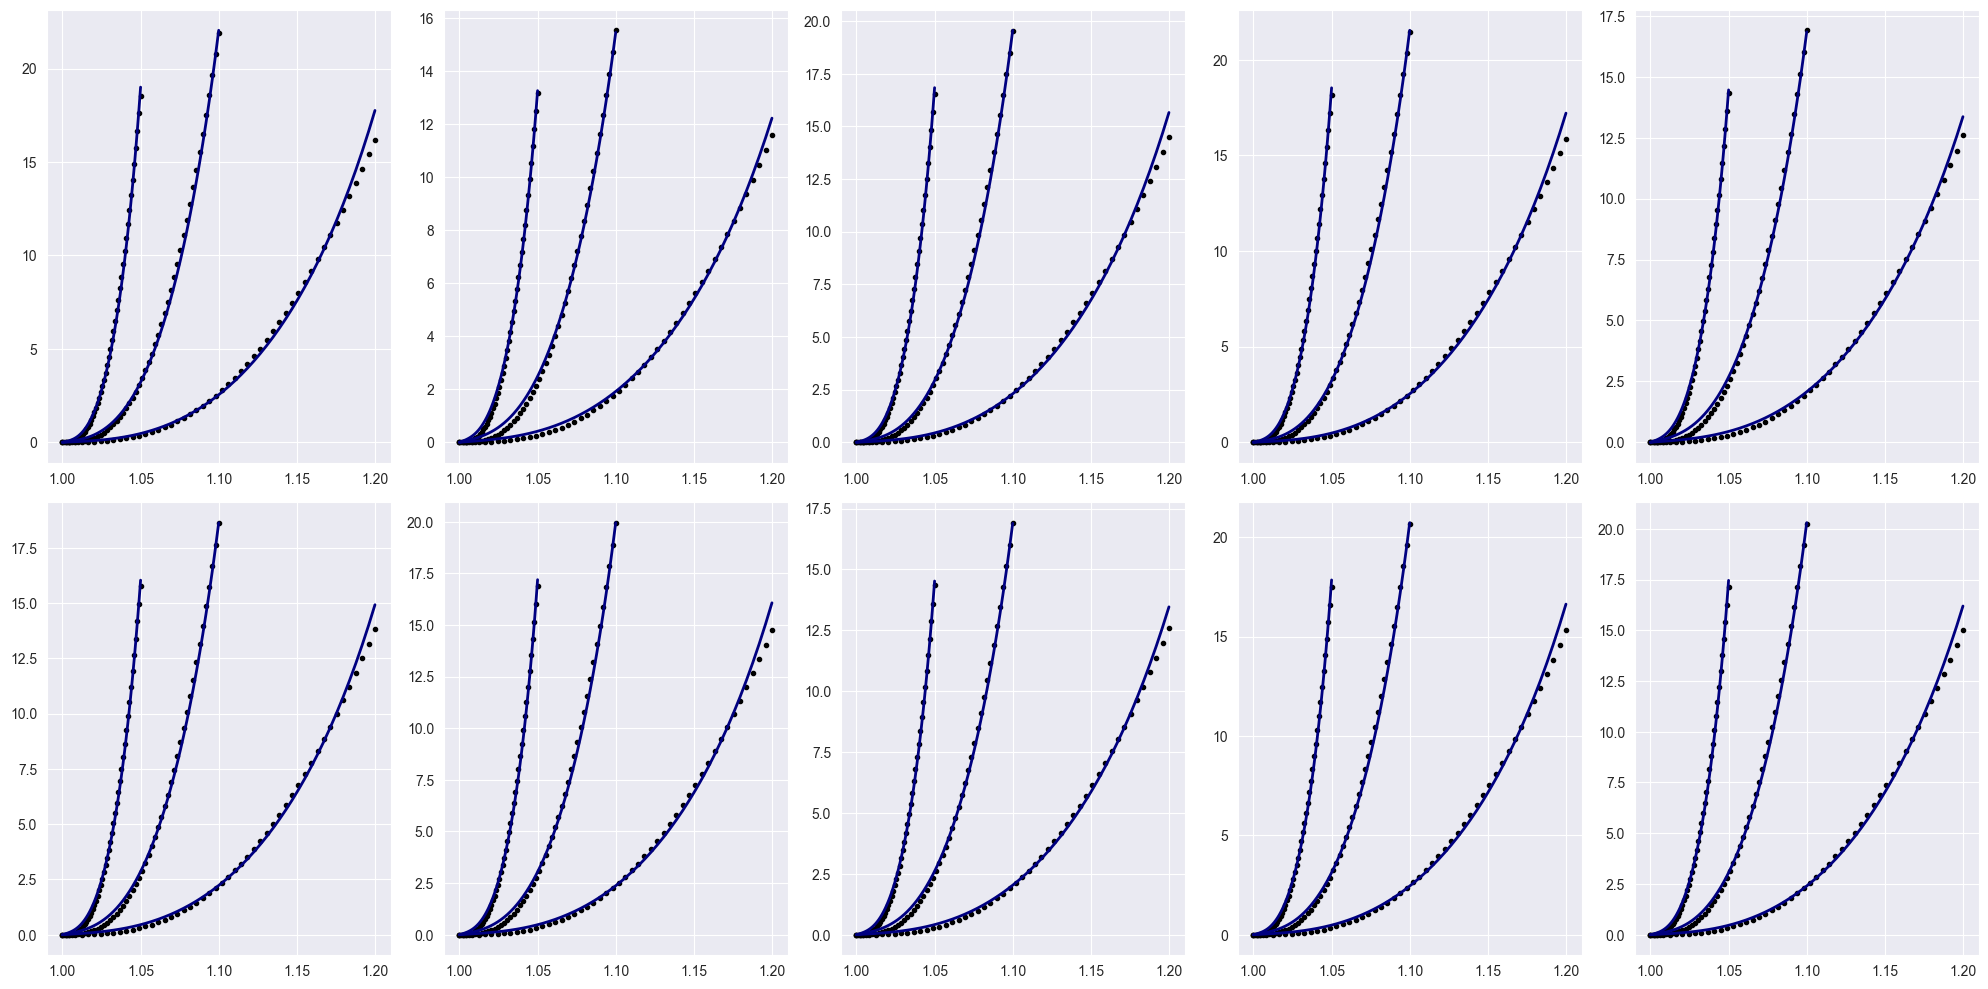

In [12]:
plt.figure(figsize = (20,10))
for i, sample_params in enumerate(Sample_params[:10]): #plot the first 10
    params_I1si,params_I2si, params_I1I2si = sample_params 
    params_I1 = (params_I1c, params_I1si)
    params_I2 = (params_I2c, params_I2si)
    params_I1I2 = (params_I1I2c, params_I1I2si, params_I1I2_a)

    mymodel = NODE_model(params_I1,params_I2,params_I1I2)
    sigx,sigy = eval_Cauchy(lamb_sigma_m[:,0],lamb_sigma_m[:,1], mymodel, normalization)
    sigx_gt = sigma_gt_s[i][0]
    sigy_gt = sigma_gt_s[i][1]

    plt.subplot(2,5,i+1)

    plt.plot(lam_vec[:50,1],        sigx[:50],      'k.',linewidth=2)
    plt.plot(lam_vec[50:2*50,0],    sigx[50:2*50],  'k.',linewidth=2)
    plt.plot(lam_vec[2*50:3*50,0],  sigx[2*50:3*50],'k.',linewidth=2)

    plt.plot(lam_vec[:50,1],        sigx_gt[:50],       color='navy',linewidth=2)
    plt.plot(lam_vec[50:2*50,0],    sigx_gt[50:2*50],   color='navy',linewidth=2)
    plt.plot(lam_vec[2*50:3*50,0],  sigx_gt[2*50:3*50], color='navy',linewidth=2)
plt.tight_layout()

In [13]:
with open('params/MN_node_params_all.npy', 'rb') as f:
    params_all = pickle.load(f)
params_I1, params_I2, params_I1I2 = params_all
params_I1c,params_I1s_m = params_I1
params_I2c,params_I2s_m = params_I2
params_I1I2c,params_I1I2s_m,params_I1I2_a = params_I1I2
with open('params/MN_node_sample_params.npy', 'rb') as f:
    Sample_params = pickle.load(f)

# Normalization factors
I1_factor = 3
I2_factor = 3
Psi1_factor = 1.0
Psi2_factor = 1.0
Psi_1_2_factor = 1.0
normalization = [I1_factor, I2_factor, Psi1_factor, Psi2_factor, Psi_1_2_factor]

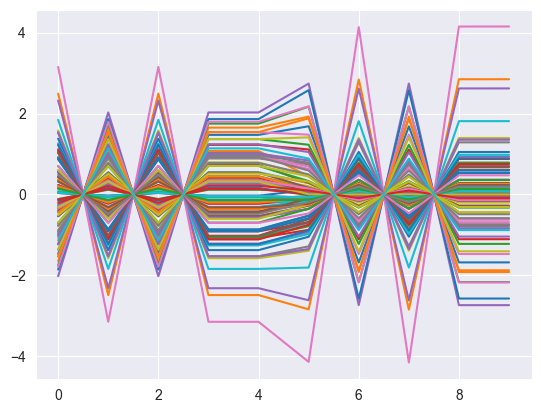

In [14]:
w_diffusion = np.array([ravel_pytree(sample_params)[0] for sample_params in Sample_params])
unravel_params = ravel_pytree(Sample_params[0])[1]

w_diffusion_I1_I2 = w_diffusion[:,0:10] # because we are note using I1-I2
mu_x  = jnp.mean(w_diffusion_I1_I2,0)
std_x = jnp.std (w_diffusion_I1_I2,0)
w_diffusion_scaled = (w_diffusion_I1_I2-mu_x)/std_x

for l in w_diffusion_scaled:
    plt.plot(l)

#### Diffusion

#### Train with all 100 samples

Epoch 0 	, Loss 1.005455 
Epoch 1000 	, Loss 0.141090 
Epoch 2000 	, Loss 0.146863 
Epoch 3000 	, Loss 0.095662 
Epoch 4000 	, Loss 0.137808 


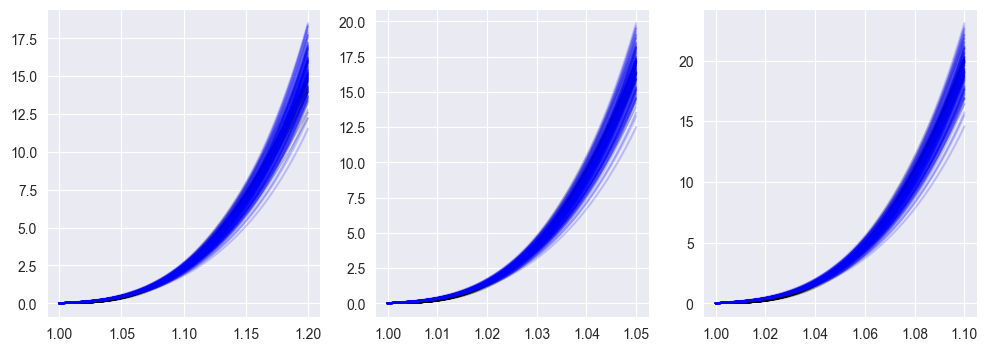

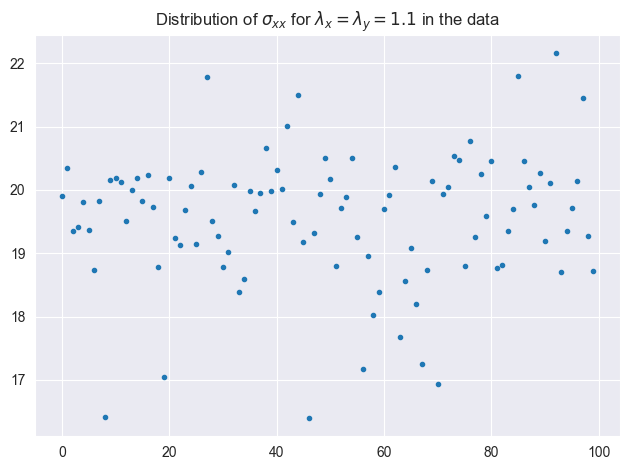

In [20]:
batch_size = 16
#some dummy input data. Flax is able to infer all the dimensions of the weights
#if we supply if with the kind of input data it has to expect
x = jnp.zeros((w_diffusion_scaled.shape[1])*batch_size).reshape((batch_size, w_diffusion_scaled.shape[1]))
time = jnp.ones((batch_size, 1))
#initialize the model weights
score_model = ApproximateScore() # from diffusion_utils
params = score_model.init(rng, x, time) # from diffusion_utils
#Initialize the optimizer
optimizer = optax.adam(5.e-4)
opt_state = optimizer.init(params)
N_epochs = 5000
train_size = w_diffusion.shape[0]
batch_size = 20
batch_size = min(train_size, batch_size)
steps_per_epoch = train_size // batch_size

params = train_diffusion(w_diffusion_scaled, score_model, N_epochs, train_size, batch_size, steps_per_epoch, rng, params, optimizer, opt_state)


# Sample using the trained params
trained_score = lambda x, t: score_model.apply(params, x, t)
rng, step_rng = random.split(rng)
samples = reverse_sde(step_rng, w_diffusion_scaled.shape[1], 100, drift, dispersion, trained_score)


# Make stress predictions and compare
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
tikzdata = [lam_vec[2*50:3*50,0]]
for l in samples:
    l_unscaled = l*std_x+mu_x 
    l_full = jnp.concatenate((l_unscaled,w_diffusion[0,10:])) 
    sample_params = unravel_params(l_full)

    params_I1si,params_I2si, params_I1I2si = sample_params 
    params_I1 = (params_I1c, params_I1si)
    params_I2 = (params_I2c, params_I2si)
    params_I1I2 = (params_I1I2c, params_I1I2si, params_I1I2_a)

    mymodel = NODE_model(params_I1,params_I2,params_I1I2)
    sigx,sigy = eval_Cauchy(lamb_sigma_m[:,0],lamb_sigma_m[:,1], mymodel, normalization)

    axs[0].plot(lam_vec[:50,1],       sigx[:50],      color='k',linewidth=1,alpha=0.1)
    axs[1].plot(lam_vec[50:2*50,0],   sigx[50:2*50],  color='k',linewidth=1,alpha=0.1)
    axs[2].plot(lam_vec[2*50:3*50,0], sigx[2*50:3*50],color='k',linewidth=1,alpha=0.1)

    tikzdata.append(sigx[2*50:3*50])

tikzdata = np.array(tikzdata)
np.savetxt('tikz/fig_analytical_data/model_100_sgmx_equi.csv', tikzdata.T, header = header, comments = '')
stat = tikzdata[1:,-1]
kernel = gaussian_kde(stat)
xmin = np.min(stat)
xmax = np.max(stat)
r = xmax-xmin
x = np.linspace(xmin - 0.3*r, xmax + 0.3*r)
y = kernel(x)
fig, ax = plt.subplots()
ax.plot(stat, '.')
ax.set(title='Distribution of $\sigma_{xx}$ for $\lambda_x=\lambda_y=1.1$ in the data')
np.savetxt('tikz/fig_analytical_data/model_100_sgmx_at_1.1_equi.csv', np.stack([x,y]).T, header='x y', comments='')


for j in range(J):
    axs[0].plot(lam_vec[:50,1],       sigma_gt_s[j][0][:50],      color='b',alpha=0.2)
    axs[1].plot(lam_vec[50:2*50,0],   sigma_gt_s[j][0][50:2*50],  color='b',alpha=0.2)
    axs[2].plot(lam_vec[2*50:3*50,0], sigma_gt_s[j][0][2*50:3*50],color='b',alpha=0.2)
plt.tight_layout()

### Training and diffusion are done. Generate the pairplot figure.

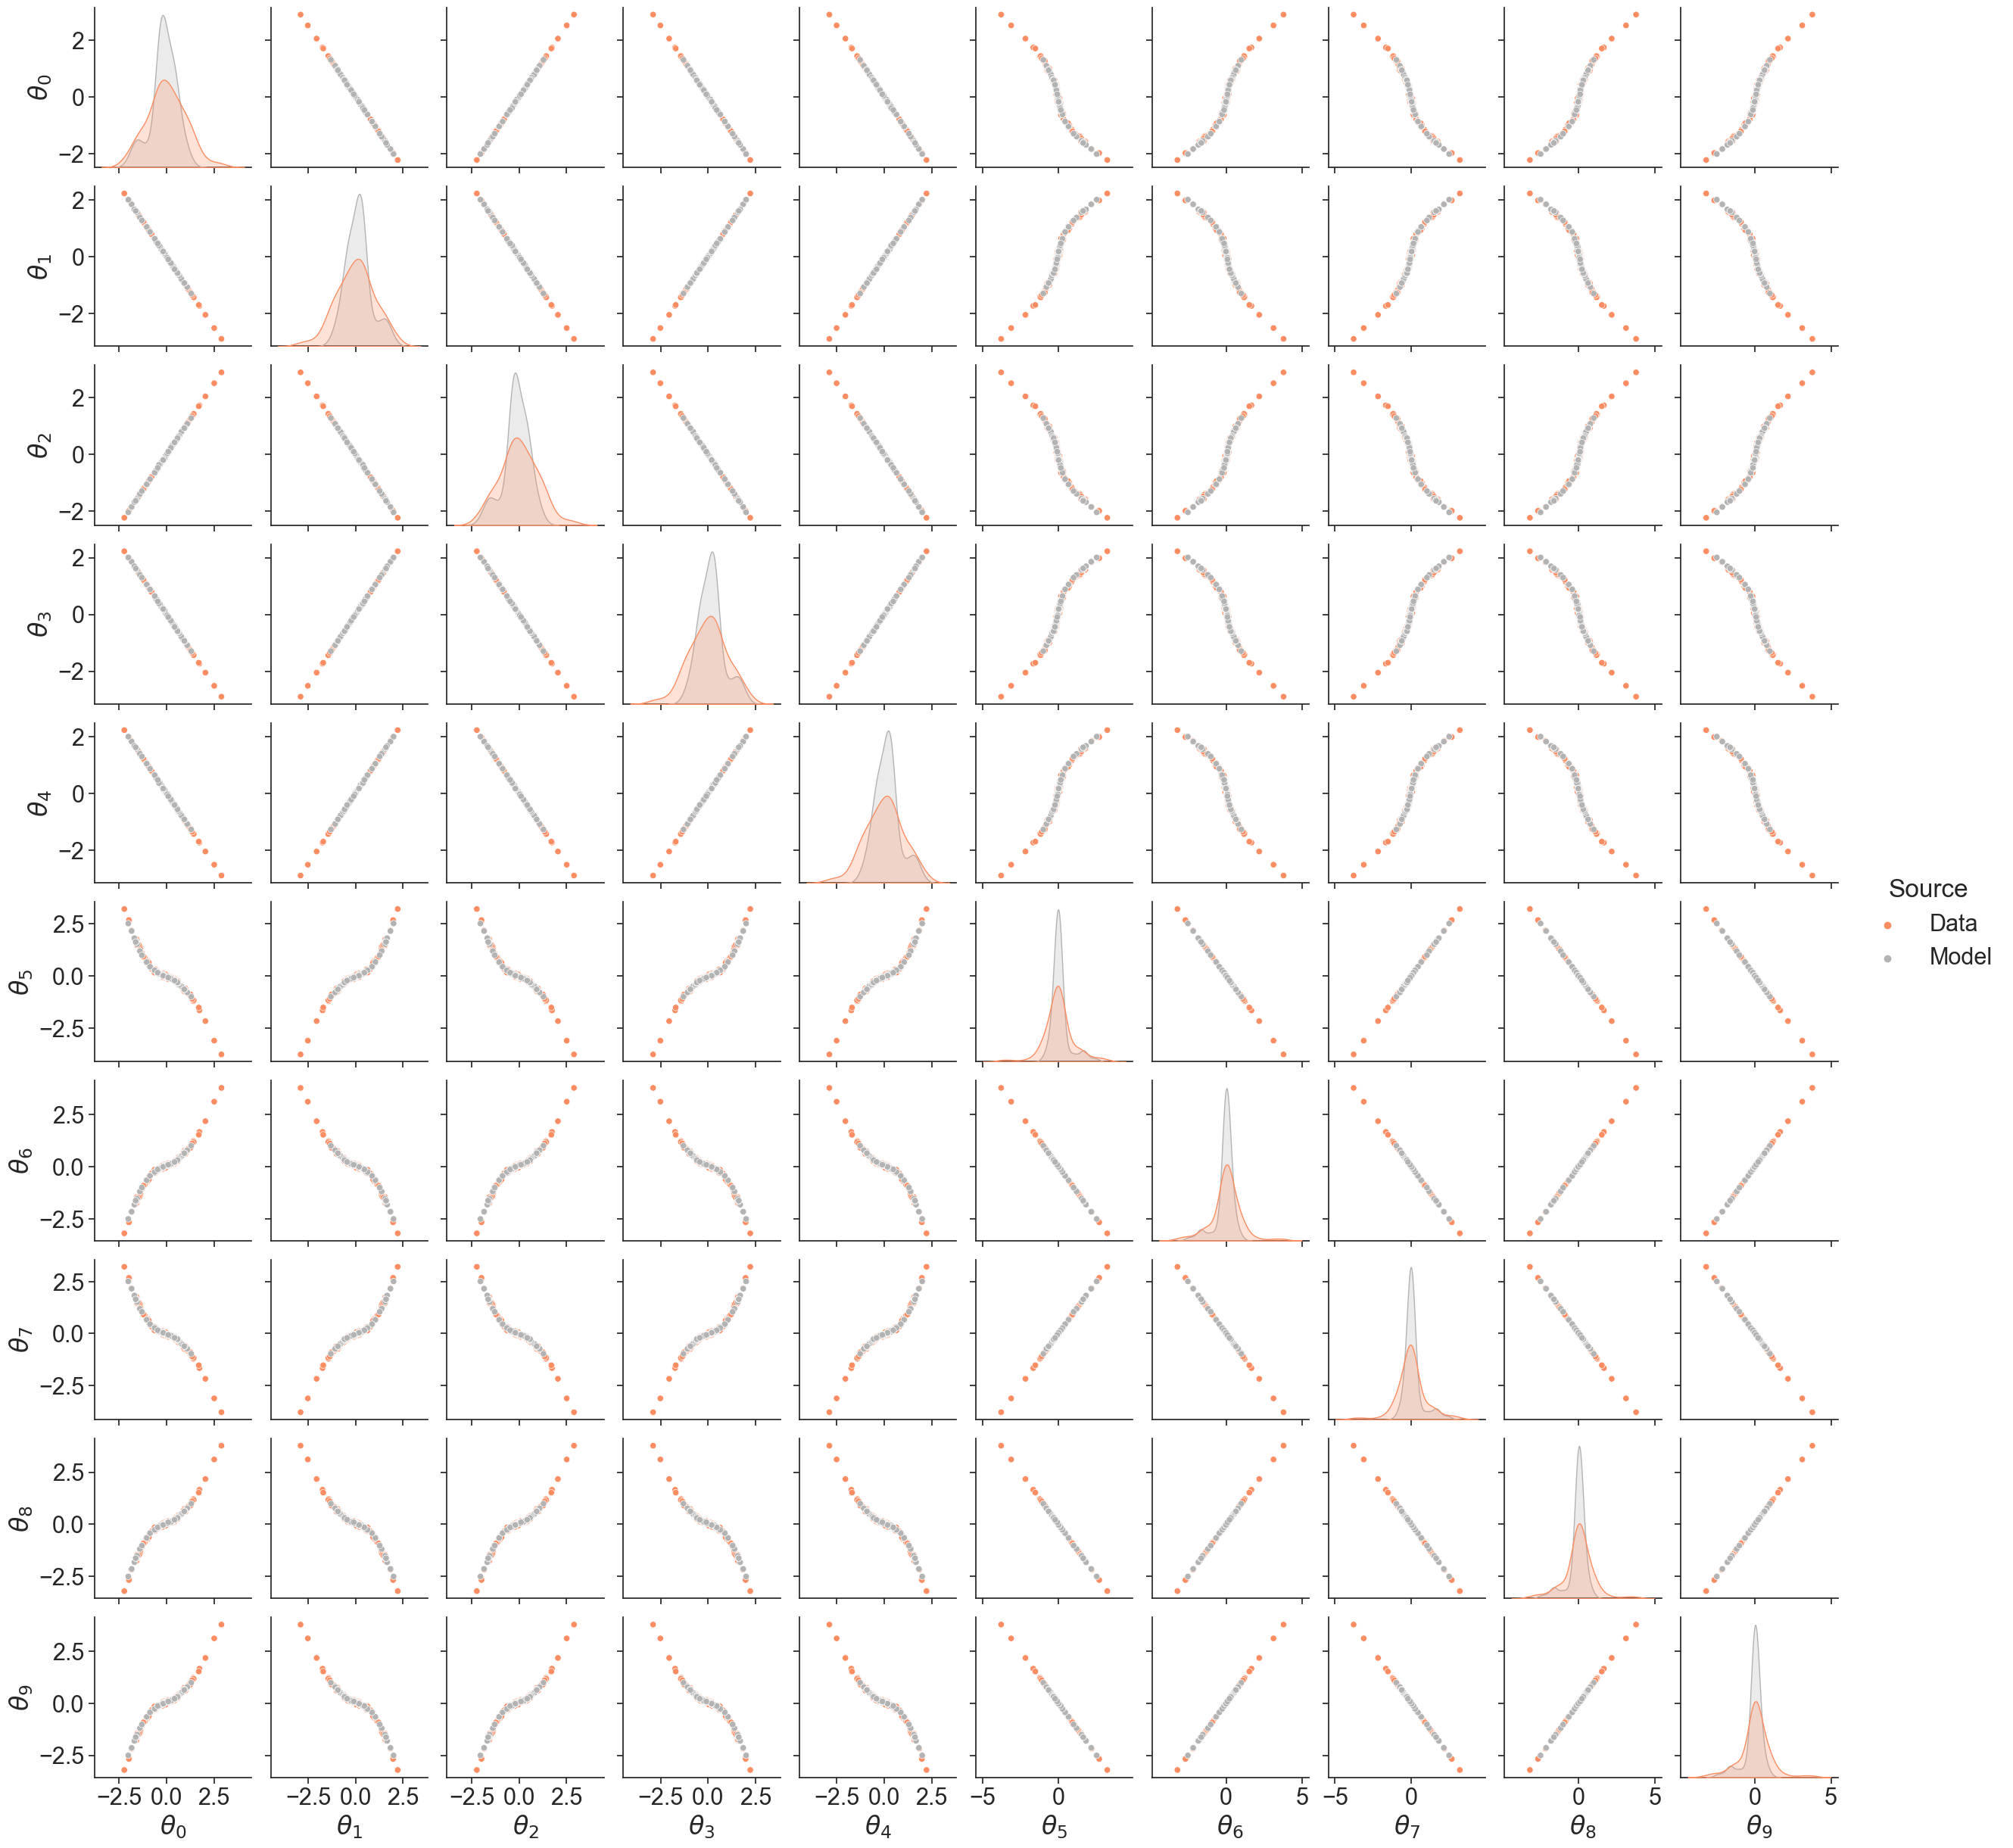

In [50]:
# Combine the diffused and original weights but add a "Source" column that says either 'Data' or 'Model' 
data1 = pd.DataFrame(w_diffusion_scaled, columns = ['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10'])
aux = pd.Series(['Data']*w_diffusion_scaled.shape[0], name='Source')
data1 = pd.concat([data1, aux], 1)

data2 = pd.DataFrame(samples, columns = ['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10'])
aux = pd.Series(['Model']*w_diffusion_scaled.shape[0], name='Source')
data2 = pd.concat([data2, aux], 1)

data = pd.concat([data1, data2])

colors = {'Data': sns.color_palette('Set2')[1], 'Model': sns.color_palette('Set2')[7]}
sns.set(font_scale=2)
sns.set_style("ticks")
fig = sns.pairplot(data, hue='Source', diag_kind='kde', palette=colors)
for i in range(10):
    fig.axes[i,0].set(ylabel='$\\theta_{}$'.format(i))
    fig.axes[9,i].set(xlabel='$\\theta_{}$'.format(i))
fig.savefig('fig_pairplot.pdf')

### Train with 100 (above), 50, 10 and 5 samples for the sensitivity figure

Epoch 0 	, Loss 1.028729 
Epoch 1000 	, Loss 0.272966 
Epoch 2000 	, Loss 0.172642 
Epoch 3000 	, Loss 0.226310 
Epoch 4000 	, Loss 0.125222 


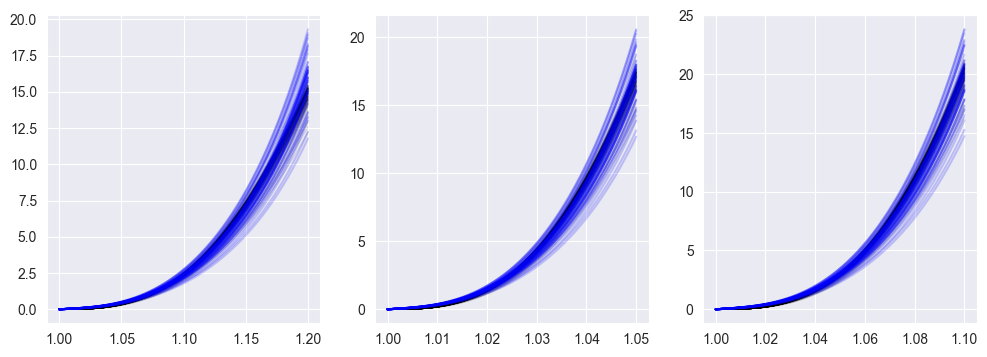

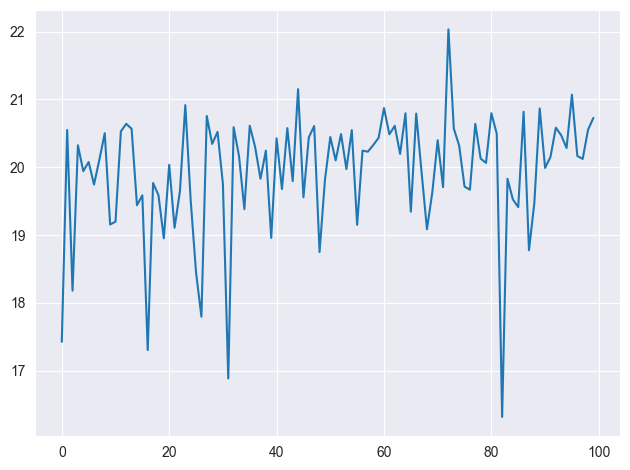

In [11]:
w_diffusion_scaled_2 = w_diffusion_scaled[:50]


batch_size = 16
#some dummy input data. Flax is able to infer all the dimensions of the weights
#if we supply if with the kind of input data it has to expect
x = jnp.zeros((w_diffusion_scaled_2.shape[1])*batch_size).reshape((batch_size, w_diffusion_scaled_2.shape[1]))
time = jnp.ones((batch_size, 1))
#initialize the model weights
score_model = ApproximateScore() # from diffusion_utils
params = score_model.init(rng, x, time) # from diffusion_utils

optimizer = optax.adam(5.0e-4)
opt_state = optimizer.init(params)
N_epochs = 5000
train_size = w_diffusion_scaled_2.shape[0]
batch_size = 20

batch_size = min(train_size, batch_size)
steps_per_epoch = train_size // batch_size
batch_size = min(train_size, batch_size)
steps_per_epoch = train_size // batch_size

params = train_diffusion(w_diffusion_scaled_2, score_model, N_epochs, train_size, batch_size, steps_per_epoch, rng, params, optimizer, opt_state)


# Sample using the trained params
trained_score = lambda x, t: score_model.apply(params, x, t)
rng, step_rng = random.split(rng)
samples = reverse_sde(step_rng, w_diffusion_scaled_2.shape[1], 100, drift, dispersion, trained_score)


# Make stress predictions and compare
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
tikzdata = [lam_vec[2*50:3*50,0]]
for l in samples:
  l_unscaled = l*std_x+mu_x 
  l_full = jnp.concatenate((l_unscaled,w_diffusion[0,10:])) 
  sample_params = unravel_params(l_full)

  params_I1si,params_I2si, params_I1I2si = sample_params 
  params_I1 = (params_I1c, params_I1si)
  params_I2 = (params_I2c, params_I2si)
  params_I1I2 = (params_I1I2c, params_I1I2si, params_I1I2_a)

  mymodel = NODE_model(params_I1,params_I2,params_I1I2)
  sigx,sigy = eval_Cauchy(lamb_sigma_m[:,0],lamb_sigma_m[:,1], mymodel, normalization)

  axs[0].plot(lam_vec[:50,1],       sigx[:50],      color='k',linewidth=1,alpha=0.1)
  axs[1].plot(lam_vec[50:2*50,0],   sigx[50:2*50],  color='k',linewidth=1,alpha=0.1)
  axs[2].plot(lam_vec[2*50:3*50,0], sigx[2*50:3*50],color='k',linewidth=1,alpha=0.1)
  tikzdata.append(sigx[2*50:3*50])
tikzdata = np.array(tikzdata)
np.savetxt('tikz/fig_analytical_data/model_50_sgmx_equi.csv', tikzdata.T, header = header, comments = '')
stat = tikzdata[1:,-1]
kernel = gaussian_kde(stat)
xmin = np.min(stat)
xmax = np.max(stat)
r = xmax-xmin
x = np.linspace(xmin - 0.3*r, xmax + 0.3*r)
y = kernel(x)
np.savetxt('tikz/fig_analytical_data/model_50_sgmx_at_1.1_equi.csv', np.stack([x,y]).T, header='x y', comments='')
fig, ax = plt.subplots()
ax.plot(stat)


for j in range(50):
    axs[0].plot(lam_vec[:50,1],       sigma_gt_s[j][0][:50],      color='b',alpha=0.2)
    axs[1].plot(lam_vec[50:2*50,0],   sigma_gt_s[j][0][50:2*50],  color='b',alpha=0.2)
    axs[2].plot(lam_vec[2*50:3*50,0], sigma_gt_s[j][0][2*50:3*50],color='b',alpha=0.2)

plt.tight_layout()

Epoch 0 	, Loss 0.916545 
Epoch 1000 	, Loss 0.582123 
Epoch 2000 	, Loss 0.464088 
Epoch 3000 	, Loss 0.304526 
Epoch 4000 	, Loss 0.241281 


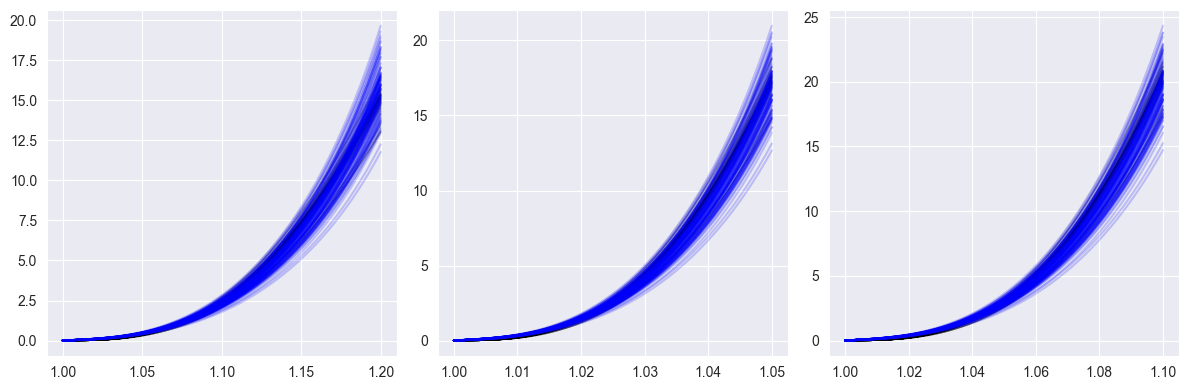

In [12]:
w_diffusion_scaled_2 = w_diffusion_scaled[:10]


batch_size = 16
#some dummy input data. Flax is able to infer all the dimensions of the weights
#if we supply if with the kind of input data it has to expect
x = jnp.zeros((w_diffusion_scaled_2.shape[1])*batch_size).reshape((batch_size, w_diffusion_scaled_2.shape[1]))
time = jnp.ones((batch_size, 1))
#initialize the model weights
score_model = ApproximateScore() # from diffusion_utils
params = score_model.init(rng, x, time) # from diffusion_utils

optimizer = optax.adam(5.0e-4)
opt_state = optimizer.init(params)
N_epochs = 5000
train_size = w_diffusion_scaled_2.shape[0]
batch_size = 10

batch_size = min(train_size, batch_size)
steps_per_epoch = train_size // batch_size

params = train_diffusion(w_diffusion_scaled_2, score_model, N_epochs, train_size, batch_size, steps_per_epoch, rng, params, optimizer, opt_state)


# Sample using the trained params
trained_score = lambda x, t: score_model.apply(params, x, t)
rng, step_rng = random.split(rng)
samples = reverse_sde(step_rng, w_diffusion_scaled_2.shape[1], 100, drift, dispersion, trained_score)


# Make stress predictions and compare
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
tikzdata = [lam_vec[2*50:3*50,0]]
for l in samples:
  l_unscaled = l*std_x+mu_x 
  l_full = jnp.concatenate((l_unscaled,w_diffusion[0,10:])) 
  sample_params = unravel_params(l_full)

  params_I1si,params_I2si, params_I1I2si = sample_params 
  params_I1 = (params_I1c, params_I1si)
  params_I2 = (params_I2c, params_I2si)
  params_I1I2 = (params_I1I2c, params_I1I2si, params_I1I2_a)

  mymodel = NODE_model(params_I1,params_I2,params_I1I2)
  sigx,sigy = eval_Cauchy(lamb_sigma_m[:,0],lamb_sigma_m[:,1], mymodel, normalization)
  
  axs[0].plot(lam_vec[:50,1],       sigx[:50],      color='k',linewidth=1,alpha=0.1)
  axs[1].plot(lam_vec[50:2*50,0],   sigx[50:2*50],  color='k',linewidth=1,alpha=0.1)
  axs[2].plot(lam_vec[2*50:3*50,0], sigx[2*50:3*50],color='k',linewidth=1,alpha=0.1)
  tikzdata.append(sigx[2*50:3*50])
tikzdata = np.array(tikzdata)
np.savetxt('tikz/fig_analytical_data/model_10_sgmx_equi.csv', tikzdata.T, header = header, comments = '')
stat = tikzdata[1:,-1]
kernel = gaussian_kde(stat)
xmin = np.min(stat)
xmax = np.max(stat)
r = xmax-xmin
x = np.linspace(xmin - 0.3*r, xmax + 0.3*r)
y = kernel(x)
np.savetxt('tikz/fig_analytical_data/model_10_sgmx_at_1.1_equi.csv', np.stack([x,y]).T, header='x y', comments='')


for j in range(J):
    axs[0].plot(lam_vec[:50,1],       sigma_gt_s[j][0][:50],      color='b',alpha=0.2)
    axs[1].plot(lam_vec[50:2*50,0],   sigma_gt_s[j][0][50:2*50],  color='b',alpha=0.2)
    axs[2].plot(lam_vec[2*50:3*50,0], sigma_gt_s[j][0][2*50:3*50],color='b',alpha=0.2)

plt.tight_layout()

Epoch 0 	, Loss 0.928323 
Epoch 1000 	, Loss 0.547152 
Epoch 2000 	, Loss 0.245576 
Epoch 3000 	, Loss 0.198331 
Epoch 4000 	, Loss 0.082696 


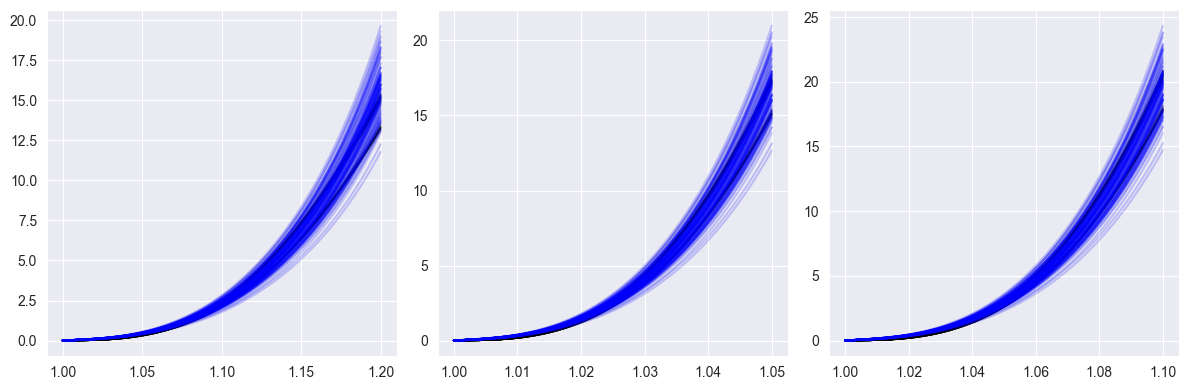

In [13]:
w_diffusion_scaled_2 = w_diffusion_scaled[:5]


batch_size = 16
#some dummy input data. Flax is able to infer all the dimensions of the weights
#if we supply if with the kind of input data it has to expect
x = jnp.zeros((w_diffusion_scaled_2.shape[1])*batch_size).reshape((batch_size, w_diffusion_scaled_2.shape[1]))
time = jnp.ones((batch_size, 1))
#initialize the model weights
score_model = ApproximateScore() # from diffusion_utils
params = score_model.init(rng, x, time) # from diffusion_utils

optimizer = optax.adam(5.0e-4)
opt_state = optimizer.init(params)
N_epochs = 5000
train_size = w_diffusion_scaled_2.shape[0]
batch_size = 5

batch_size = min(train_size, batch_size)
steps_per_epoch = train_size // batch_size

params = train_diffusion(w_diffusion_scaled_2, score_model, N_epochs, train_size, batch_size, steps_per_epoch, rng, params, optimizer, opt_state)


# Sample using the trained params
trained_score = lambda x, t: score_model.apply(params, x, t)
rng, step_rng = random.split(rng)
samples = reverse_sde(step_rng, w_diffusion_scaled_2.shape[1], 100, drift, dispersion, trained_score)


# Make stress predictions and compare
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
tikzdata = [lam_vec[2*50:3*50,0]]
for l in samples:
  l_unscaled = l*std_x+mu_x 
  l_full = jnp.concatenate((l_unscaled,w_diffusion[0,10:])) 
  sample_params = unravel_params(l_full)

  params_I1si,params_I2si, params_I1I2si = sample_params 
  params_I1 = (params_I1c, params_I1si)
  params_I2 = (params_I2c, params_I2si)
  params_I1I2 = (params_I1I2c, params_I1I2si, params_I1I2_a)

  mymodel = NODE_model(params_I1,params_I2,params_I1I2)
  sigx,sigy = eval_Cauchy(lamb_sigma_m[:,0],lamb_sigma_m[:,1], mymodel, normalization)
  
  axs[0].plot(lam_vec[:50,1],       sigx[:50],      color='k',linewidth=1,alpha=0.1)
  axs[1].plot(lam_vec[50:2*50,0],   sigx[50:2*50],  color='k',linewidth=1,alpha=0.1)
  axs[2].plot(lam_vec[2*50:3*50,0], sigx[2*50:3*50],color='k',linewidth=1,alpha=0.1)
  tikzdata.append(sigx[2*50:3*50])
tikzdata = np.array(tikzdata)
np.savetxt('tikz/fig_analytical_data/model_5_sgmx_equi.csv', tikzdata.T, header = header, comments = '')
stat = tikzdata[1:,-1]
kernel = gaussian_kde(stat)
xmin = np.min(stat)
xmax = np.max(stat)
r = xmax-xmin
x = np.linspace(xmin - 0.3*r, xmax + 0.3*r)
y = kernel(x)
np.savetxt('tikz/fig_analytical_data/model_5_sgmx_at_1.1_equi.csv', np.stack([x,y]).T, header='x y', comments='')


for j in range(J):
    axs[0].plot(lam_vec[:50,1],       sigma_gt_s[j][0][:50],      color='b',alpha=0.2)
    axs[1].plot(lam_vec[50:2*50,0],   sigma_gt_s[j][0][50:2*50],  color='b',alpha=0.2)
    axs[2].plot(lam_vec[2*50:3*50,0], sigma_gt_s[j][0][2*50:3*50],color='b',alpha=0.2)

plt.tight_layout()